# 간단한 단어분류 프로젝트를 통한 자연어처리 이해

#1. 프로젝트의 목적

이번 프로젝트는 문장의 각 단어를 명사(1)와 기타(0)로 분류하는 단어 단위 분류모델입니다.

이와 같이 각 단어별로 예측하는 Task는 다음과 같은 종류들이 있습니다.

- NER(Named Entity Recognition) : 문장 내의 각 단어를 '사람','장소','시간' 등의 정보로 분류하는 Task입니다.
- POS(Part Of Speech) Tagging : 문장 내의 각 단어를 '명사', '동사','부사'등 품사로 분류하는 Task입니다.
- Language Model: 생성할 문장의 각 단어에 대한 다음 단어를 예측하는 방식으로 동작합니다.

#2. 프로젝트 Workflow

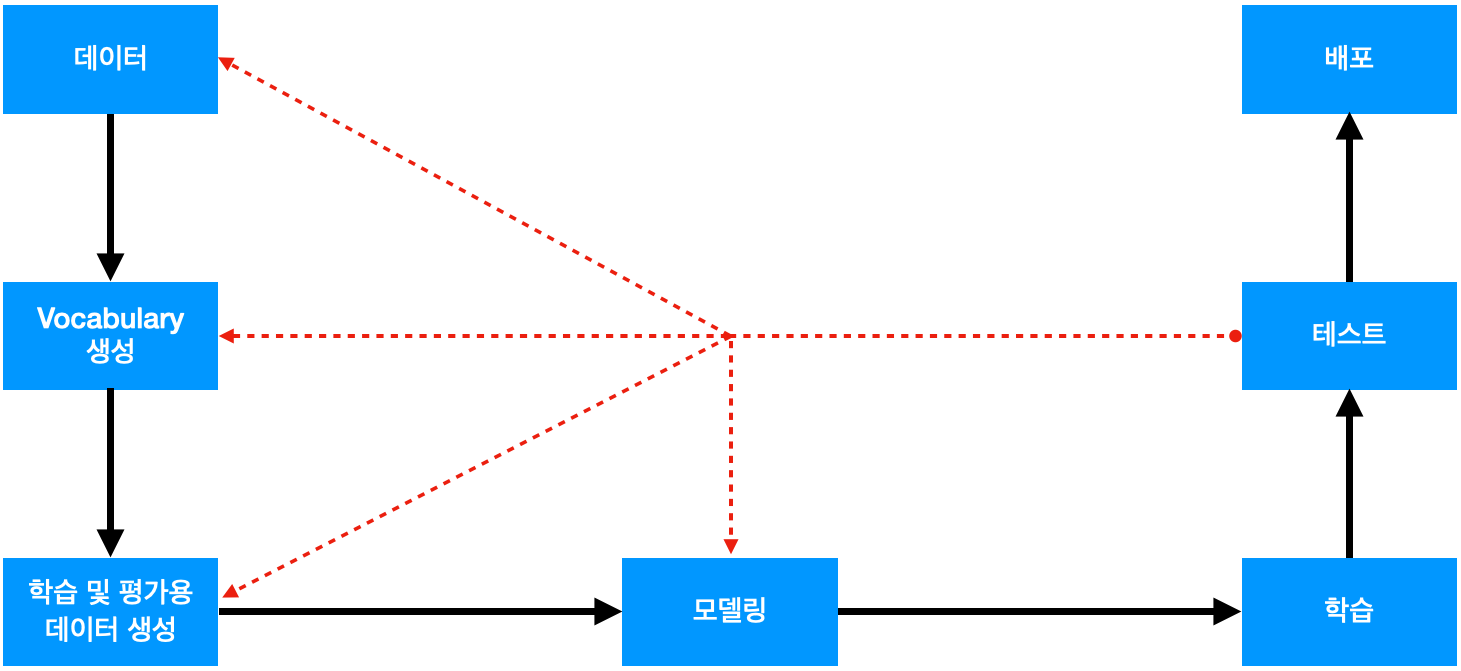

- 데이터
 - 목적에 필요한 정답이 포함된 데이터를 수집하거나 직접 생성 합니다.
 - 이 프로젝트의 경우는 각 단어가 명사인지 여부를 표시해놓은 데이터가 필요합니다.
- Vocabulary 생성
 - 수집된 데이터를 일정한 단위로 일련번호를 부여하는 과정입니다.
 - 자연어처리에서는 컴퓨터에 입력할 때 글자가 아닌 vocabulary에 부여된 일련번호를 입력합니다.
- 학습 및 평가용 데이터 생성
 - 데이터를 vocabulary를 이용해서 일련번호로 변경 후 학습에 적합한 형태로 가공하는 과정입니다.
- 모델링
 - 목적에 적합한 모델을 생성합니다.
- 학습
 - 데이터를 이용해서 모델을 학습하는 과정입니다.
- 테스트
 - 학습된 모델을 테스트하는 과정입니다.
 - 모델을 테스트해서 성능이 기준치보다 좋으면 서비스에 배포 합니다.
 - 만일 모델의 성능이 기준치보다 성능이 낮은 경우는 원인을 분석하고 문제가 된다고 생각되는 과정으로 돌아가서 그 과정을 개선하고 다시 학습하고 테스트해 봅니다.
- 배포
 - 학습된 모델을 이용하여 실제 문제에 적용해서 문제를 개선하는 과정입니다.

#3. 프로젝트 환경

In [1]:
# 필요한 library import

import argparse
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# 학습 환경 설정

args = {
    # random seed value
    "seed": 9999,
    # number of epoch
    "n_epoch": 200,
    # number of batch
    "n_batch": 2,
    # learning rate
    "lr": 0.001,
    # weights 저장 위치
    "save_path": "01-01-sequence-prediction.pth",
    # CPU 또는 GPU 사용여부 결정
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=9999, n_epoch=200, n_batch=2, lr=0.001, save_path='01-01-sequence-prediction.pth', device=device(type='cpu'))


Random seed를 설정하는 이유는 pytorch가 random하게 초깃값을 설정하는데 이 값이 다를 경우 학습 결과가 달라질 수 있어서 항상 같은 값을 가지도록 하기 위해서입니다.

In [3]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

#4. 데이터

목적에 맞는 데이터를 수집하고 정답 라벨은 만드는 과정은 어렵고 전체 과정 중 가장 중요한 과정이라고 할 수 있습니다.

수집된 데이터를 학습용(60%),검증용(20%),테스트용(20%) 형태로 분할하는 것이 일반적이나, 만일 데이터 수가 적다면 학습용(80%), 검증용 및 테스트용(20%) 형태로 분할합니다.
중요한 것은 학습용 이외에 적당한 양의 평가 데이터가 필요하다는 것입니다.

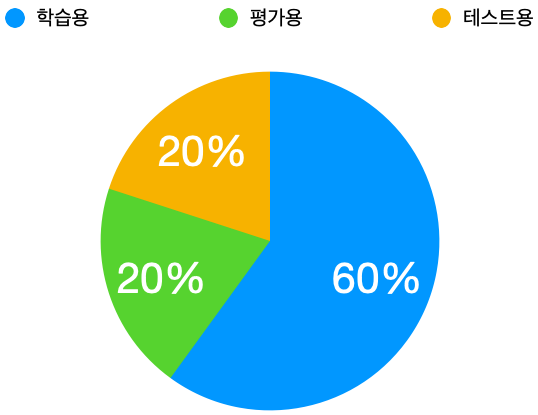

In [4]:
# 입력 문장 (학습용 데이터)

raw_inputs = [
    "나는 학생 입니다",
    "당신은 존경받는 교수님 입니다",
    "당신은 매우 좋은 교수님 입니다"
]

In [5]:
# 정답 데이터 : 명사(1), 기타(0)

raw_labels = [
    [0,1,0],
    [0,0,1,0],
    [0,0,0,1,0]
]

#5. Vocabulary 생성

Vocabulary는 입력할 문장을 일정한 단위로 일련번호를 부여하는 것을 의미합니다.
컴퓨터에는 우리가 인식하는 글자를 직접 입력할 수 없기 때문에 Vocabulary의 일련번호로 변경해서 입력해야 합니다.

Vocabulary를 구성하기 위한 분할의 단위는 ‘글자 단위’, ‘띄어쓰기 단위’로 분할하거나 ‘형태소 단위’로 분할하는 등 다양한 방법이 있습니다.
이번 프로젝트에서는 가장 간단한 ‘띄어쓰기 단위’로 분할한 Vocabulary를 사용합니다.

우선 학습할 전체 문장을 띄어쓰기 단위로 분할합니다.

In [6]:
# 문장을 띄어쓰기 단위로 분할

words = []
for s in raw_inputs:
  words.extend(s.split())

print(words)

['나는', '학생', '입니다', '당신은', '존경받는', '교수님', '입니다', '당신은', '매우', '좋은', '교수님', '입니다']


In [ ]:
# 중복단어 제거
word = list(dict.fromkets(words))

print(words)

이제 각 단어에 일련번호를 부여합니다.
이때 추가로 특수값 [PAD],[UNK] 2개를 지정합니다.
- 자연어 처리에서는 특성상 문장의 길이가 다를 수 있기 때문에 길이가 짧은 문장의 뒷부분 또는 앞부분에 [PAD]를 추가해 줍니다.
이렇게 하면 여러개의 문장을 동시에 처리할 수 있습니다.
- 입력문장 중에 vocabulary에 없는 단어가 포함되어 있을 수 있습니다. 이때 이 단어를 [UNK]로 변경해서 처리합니다.

In [ ]:
# 각 단어별 일련번호
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    word_to_id[w] = len(word_to_id)

print(word_to_id)

In [ ]:
# 각 일련 번호별로 단어 부여
id_to_word = {i: w for w, i in word_to_id.items()}

print(id_to_word)

#6. 학습 및 평가용 데이터 생성

이제 만들어진 Vocabulary를 이용해서 입력데이터를 학습이 가능한 일련번호 형태로 변경합니다



In [ ]:
# 입력 데이터
inputs = []
for s in raw_inputs:
    inputs.append([word_to_id[w] for w in s.split()])

print(inputs)

# 정답 데이터
labels = raw_labels

print(labels)

다음은 데이터를 처리할 DataSet 클래스를 정의합니다.

In [ ]:
class SimpleDataSet(torch.utils.data.Dataset):
    """ 데이터셋 클래스 """

    def __init__(self, inputs, labels):
        """
        생성자. 데이터 관련한 값을 인자로 전달.
        :param inputs: 입력
        :param labels: 정답
        """
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        """ 데이터셋 길이 """
        assert len(self.inputs) == len(self.labels)
        return len(self.labels)

    def __getitem__(self, index):
        """
        데이터 한 개 조회
        DataSet에서 한 개의 특정한 item을 조회할 때 사용
        :param index: 데이터 위치
        """
        return (
            torch.tensor(self.inputs[index]),
            torch.tensor(self.labels[index]),
        )

    def collate_fn(self, batch):
        """
        batch단위로 데이터 처리
        입력문장의 길이가 다를 경우 짧은 문장의 뒷부분에 [PAD]를 의미하는 0을 추가해서 문장의 길이를 동일하게 만들어주는 역할
        :param batch: batch 단위 데이터
        """
        inputs, labels = list(zip(*batch))

        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

        batch = [
            inputs,
            labels,
        ]

        return batch

In [ ]:
# dataset 클래스 생성

dataset = SimpleDataSet(inputs, labels)

print(len(dataset))

다음은 데이터의 순서를 섞기 위한 sampler를 생성합니다.

학습용 데이터의 경우는 고정된 데이터 순서를 여러 번 반복해서 학습하게 되면 데이터 순서에서 오는 편향이 발생할 수 있습니다.
이를 완화하기위해서 순서를 섞습니다.

반면 검증 및 테스트 데이터는 학습하지 않기 때문에 순서를 섞지 않습니다.

In [ ]:
# random sample data
sampler = torch.utils.data.RandomSampler(dataset)

다음으로 학습용 데이터를 처리하기 위한 Train data loader를 생성합니다.

In [ ]:
# train loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=sampler, collate_fn=dataset.collate_fn)


위 코드의 설명은 다음과 같습니다.

- batch_size = 2 : 한 번에 데이터를 두개씩 처리하겠다는 의미입니다.
- batch_size가 2이기 때문에 입력문장의 길이가 다를 수 있습니다. 이 경우 데이터 길이를 맞추기 위해서 collate_fn을 지정합니다.
- 학습 데이터의 경우는 순서를 섞어주기 위해서 sampler를 추가했습니다.

다음은 검증용 데이터를 처리하기 위한 Valid data loader를 생성합니다.

검증용 데이터는 학습용 데이터와 다른 데이터를 사용해야 하지만 지금은 자연어처리를 이해하는 데 목적이 있기 때문에 같은 데이터를 사용하겠습니다.

In [ ]:

# dataset
dataset = SimpleDataSet(inputs, labels)
# valid loader
valid_loader = torch.utils.data.DataLoader(dataset

검증용 데이터와 동일한 방법으로 테스트용 데이터 처리를 위한 Test data loader를 생성합니다.



In [ ]:
# dataset
dataset = SimpleDataSet(inputs, labels)
# test loader
test_loader = torch.utils.data.DataLoader(dataset, batch_size

#7.1 모델링(Tutorial)

이제 단어분류를 할 모델을 생성합니다. 간단하게 모델의 동작을 직접 확인해 본 후 모델 클래스를 생성해 보도록 하겠습니다.

우선 입력을 정의합니다.